--- STARTING AUTO-CALIBRATION ---
Found 7 vertical grid lines.
Found 7 horizontal grid lines.
Calibration Successful!

--- EXTRACTED GIS COORDINATES (Rwanda Grid) ---
[512496.27, 4749331.38]
[512496.36, 4749262.37]
[512590.74, 4749262.37]
[512590.74, 4749331.47]


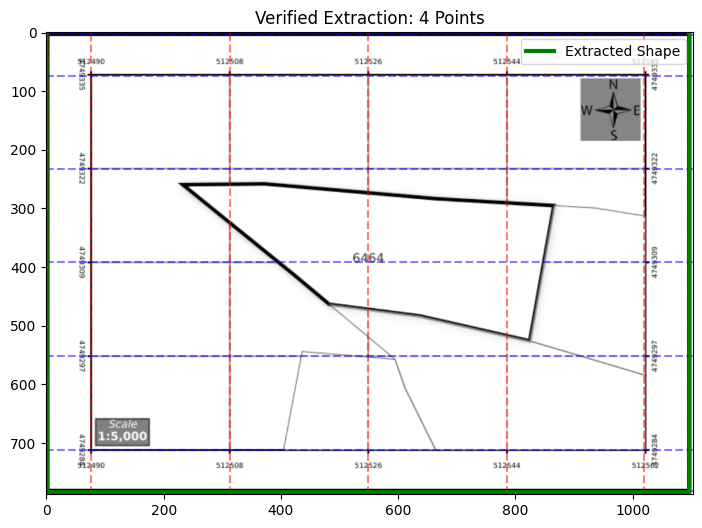


CALCULATED AREA: 6520.39 sqm
(Compare this to the document text: 642 sqm)


In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
IMAGE_PATH = 'image.png' # Ensure this matches your uploaded file name

# THESE ARE THE NUMBERS READ FROM YOUR MAP IMAGE AXIS
# We list them in order (Left -> Right for X, Top -> Bottom for Y)
KNOWN_X_COORDS = [512490, 512508, 512526, 512544, 512562] 
KNOWN_Y_COORDS = [4749335, 4749322, 4749309, 4749297, 4749284]

# ==========================================
# 2. IMAGE PROCESSING (You already mastered this part!)
# ==========================================
img = cv2.imread(IMAGE_PATH)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Isolate Bold Parcel
kernel = np.ones((3,3), np.uint8)
bold_lines = cv2.erode(binary, kernel, iterations=1)
bold_lines = cv2.dilate(bold_lines, kernel, iterations=1)

# Find the Parcel Contour
contours, _ = cv2.findContours(bold_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
target_contour = max(contours, key=cv2.contourArea) # Assume largest shape is the parcel

# Get vertices of the shape (in pixels)
epsilon = 0.01 * cv2.arcLength(target_contour, True)
pixel_vertices = cv2.approxPolyDP(target_contour, epsilon, True).reshape(-1, 2)

# ==========================================
# 3. AUTO-CALIBRATION (The Missing Link)
# ==========================================
print("--- STARTING AUTO-CALIBRATION ---")

# Detect ALL lines (Grid + Borders)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Tuned parameters for your specific image resolution
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=50)

vertical_lines = []
horizontal_lines = []

for line in lines:
    x1, y1, x2, y2 = line[0]
    if abs(x1 - x2) < 5: # Vertical Line
        vertical_lines.append(x1)
    elif abs(y1 - y2) < 5: # Horizontal Line
        horizontal_lines.append(y1)

# Helper to remove duplicate lines found closely together
def clean_lines(lines_list, tolerance=20):
    lines_list.sort()
    clean = []
    if not lines_list: return []
    curr = lines_list[0]
    count = 1
    for i in range(1, len(lines_list)):
        if lines_list[i] - curr < tolerance:
            # Average the position for accuracy
            curr = (curr * count + lines_list[i]) / (count + 1)
            count += 1
        else:
            clean.append(curr)
            curr = lines_list[i]
            count = 1
    clean.append(curr)
    return clean

# Get unique grid line pixel positions
found_v_pixels = clean_lines(vertical_lines)
found_h_pixels = clean_lines(horizontal_lines)

print(f"Found {len(found_v_pixels)} vertical grid lines.")
print(f"Found {len(found_h_pixels)} horizontal grid lines.")

# MATCHING LOGIC: 
# We assume the detected lines correspond to the known coords in order.
# We take the middle 3 lines to avoid image border issues.
if len(found_v_pixels) >= 3 and len(found_h_pixels) >= 3:
    
    # Select Training Data (Pixels vs Meters)
    # We define X model
    X_pixels = np.array(found_v_pixels[:len(KNOWN_X_COORDS)]).reshape(-1, 1)
    X_meters = np.array(KNOWN_X_COORDS[:len(X_pixels)])
    
    # We define Y model
    Y_pixels = np.array(found_h_pixels[:len(KNOWN_Y_COORDS)]).reshape(-1, 1)
    Y_meters = np.array(KNOWN_Y_COORDS[:len(Y_pixels)])

    # Train Linear Regression (The "Map")
    model_x = LinearRegression().fit(X_pixels, X_meters)
    model_y = LinearRegression().fit(Y_pixels, Y_meters)
    
    print("Calibration Successful!")
    
    # ==========================================
    # 4. FINAL EXTRACTION & PLOT
    # ==========================================
    real_world_coords = []
    
    print("\n--- EXTRACTED GIS COORDINATES (Rwanda Grid) ---")
    for px, py in pixel_vertices:
        # Convert Pixel to Meter
        gx = model_x.predict([[px]])[0]
        gy = model_y.predict([[py]])[0]
        real_world_coords.append([gx, gy])
        print(f"[{gx:.2f}, {gy:.2f}]")

    # VISUAL VERIFICATION
    # 1. Show where we found the grid lines
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for vx in found_v_pixels:
        plt.axvline(vx, color='r', linestyle='--', alpha=0.5)
    for hy in found_h_pixels:
        plt.axhline(hy, color='b', linestyle='--', alpha=0.5)
    
    # 2. Draw the extracted polygon shape
    poly = np.array(pixel_vertices)
    plt.plot(poly[:,0], poly[:,1], 'g-', linewidth=3, label='Extracted Shape')
    plt.title(f"Verified Extraction: {len(real_world_coords)} Points")
    plt.legend()
    plt.show()
    
    # Calculate Area to verify (Shoelace Formula)
    x = np.array([p[0] for p in real_world_coords])
    y = np.array([p[1] for p in real_world_coords])
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    print(f"\nCALCULATED AREA: {area:.2f} sqm")
    print(f"(Compare this to the document text: 642 sqm)")

else:
    print("ERROR: Could not find enough grid lines to calibrate automatically.")
    print("Try adjusting the 'threshold' or 'minLineLength' in HoughLinesP.")